In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [39]:
# 1. Load train & test
train = pd.read_csv('../data/application_train.csv')
test  = pd.read_csv('../data/application_test.csv')

print(train.columns.tolist())
print(test.columns.tolist())

# Direct protected class features: 
['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# Indirect proxies: 
['OWN_CAR_AGE','CNT_CHILDREN']

# Suspicious:
['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [40]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [41]:
# 2. Fix DAYS_EMPLOYED anomaly
train['DAYS_EMPLOYED_ANOM'] = (train['DAYS_EMPLOYED'] == 365243).astype(int)
test['DAYS_EMPLOYED_ANOM']  = (test['DAYS_EMPLOYED'] == 365243).astype(int)

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({365243: np.nan})
test['DAYS_EMPLOYED']  = test['DAYS_EMPLOYED'].replace({365243: np.nan})

In [42]:
# 3. Drop the same columns from train & test BEFORE encoding
cols_to_drop = [
    "SK_ID_CURR",
    "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START",
    "WALLSMATERIAL_MODE", "N"
]

# biased_cols = ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE','CNT_CHILDREN']
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

train.drop(columns=cols_to_drop, errors="ignore", inplace=True)
test.drop(columns=cols_to_drop, errors="ignore", inplace=True)


In [43]:
def preprocess_and_encode(train_df, test_df, target_col="TARGET"):
    """
    Returns:
        X_enc, X_test_enc, y, feature_names, ct
    """
    import pandas as pd
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

    # 1. Split target
    y = train_df[target_col]
    train_X = train_df.drop(columns=[target_col])

    # 2. Align train/test
    train_X, test_X = train_X.align(test_df, join="inner", axis=1)

    # 3. Identify categorical columns
    one_hot_cols = [
        'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
        'EMERGENCYSTATE_MODE'
    ]

    # Keep only those present
    one_hot_cols = [c for c in one_hot_cols if c in train_X.columns]

    # 4. Split binary vs multi
    binary_cats = []
    multi_cats = []

    for col in one_hot_cols:
        unique_vals = train_X[col].dropna().unique()
        if len(unique_vals) <= 2:
            binary_cats.append(col)
        else:
            multi_cats.append(col)

    # 5. Build ColumnTransformer
    ct = ColumnTransformer(
        transformers=[
            ("binary", OrdinalEncoder(), binary_cats),
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cats),
        ],
        remainder="passthrough"
    )

    # 6. Fit/transform
    X_enc = ct.fit_transform(train_X)
    X_test_enc = ct.transform(test_X)

    feature_names = ct.get_feature_names_out()

    return X_enc, X_test_enc, y, feature_names, ct

def make_numeric_for_corr(df):
    df_corr = df.copy()
    for col in df_corr.columns:
        # Convert objects/categories to integer codes for correlation
        if df_corr[col].dtype == 'object' or str(df_corr[col].dtype).startswith('category'):
            df_corr[col] = df_corr[col].astype('category').cat.codes
    return df_corr



In [44]:
# Prepare biased versions (original)
train_biased = train.copy()
test_biased = test.copy()

biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

# Prepare unbiased versions
# train_unbiased = train.copy()
# test_unbiased = test.copy()

train_corr = make_numeric_for_corr(train)
corr = train_corr.corr()

valid_bcols = [b for b in biased_cols if b in corr.columns]

corr_sub = corr[valid_bcols]

corr['CODE_GENDER'].sort_values(ascending=False)[:10]

cutoff = 0.1

biased_proxies = []
proxy_features = set()
proxy_features = proxy_features - set(valid_bcols)


for bcol in valid_bcols:
    # Identify features whose absolute correlation exceeds the cutoff
    high_corr_features = corr.index[corr[bcol].abs() > cutoff].tolist()
    
    # Add them to the proxy set
    proxy_features.update(high_corr_features)

proxy_features = proxy_features - set(valid_bcols)

for bcol in valid_bcols:
    subset = corr[bcol].abs().sort_values(ascending=False)
    subset = subset.drop(labels=bcol, errors='ignore')
    biased_proxies.append(subset)

biased_table = pd.concat(biased_proxies, axis=1)
biased_table.columns = valid_bcols        # MATCHING LENGTH
biased_table = biased_table.fillna(0)
biased_table.sort_values(by=valid_bcols, ascending=False, inplace=True)

print(biased_table.head())

print(proxy_features)
print(f"{len(proxy_features)} proxy features identified.")
print(f"This is {(len(proxy_features) / len(train_biased.columns)) * 100:.2f}% of the total.")

                    CODE_GENDER  DAYS_BIRTH
FLAG_OWN_CAR           0.345833    0.129879
EXT_SOURCE_1           0.306700    0.600610
FLAG_DOCUMENT_8        0.249767    0.113243
ORGANIZATION_TYPE      0.163879    0.395304
DAYS_EMPLOYED_ANOM     0.157318    0.619947
{'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_6', 'FLAG_OWN_CAR', 'REG_REGION_NOT_WORK_REGION', 'NAME_HOUSING_TYPE', 'CNT_CHILDREN', 'LIVE_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE', 'DAYS_REGISTRATION', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'DAYS_EMPLOYED_ANOM', 'FLAG_DOCUMENT_8', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_3', 'EXT_SOURCE_3', 'LIVE_REGION_NOT_WORK_REGION'}
26 proxy features identified.
This is 21.85% of the total.


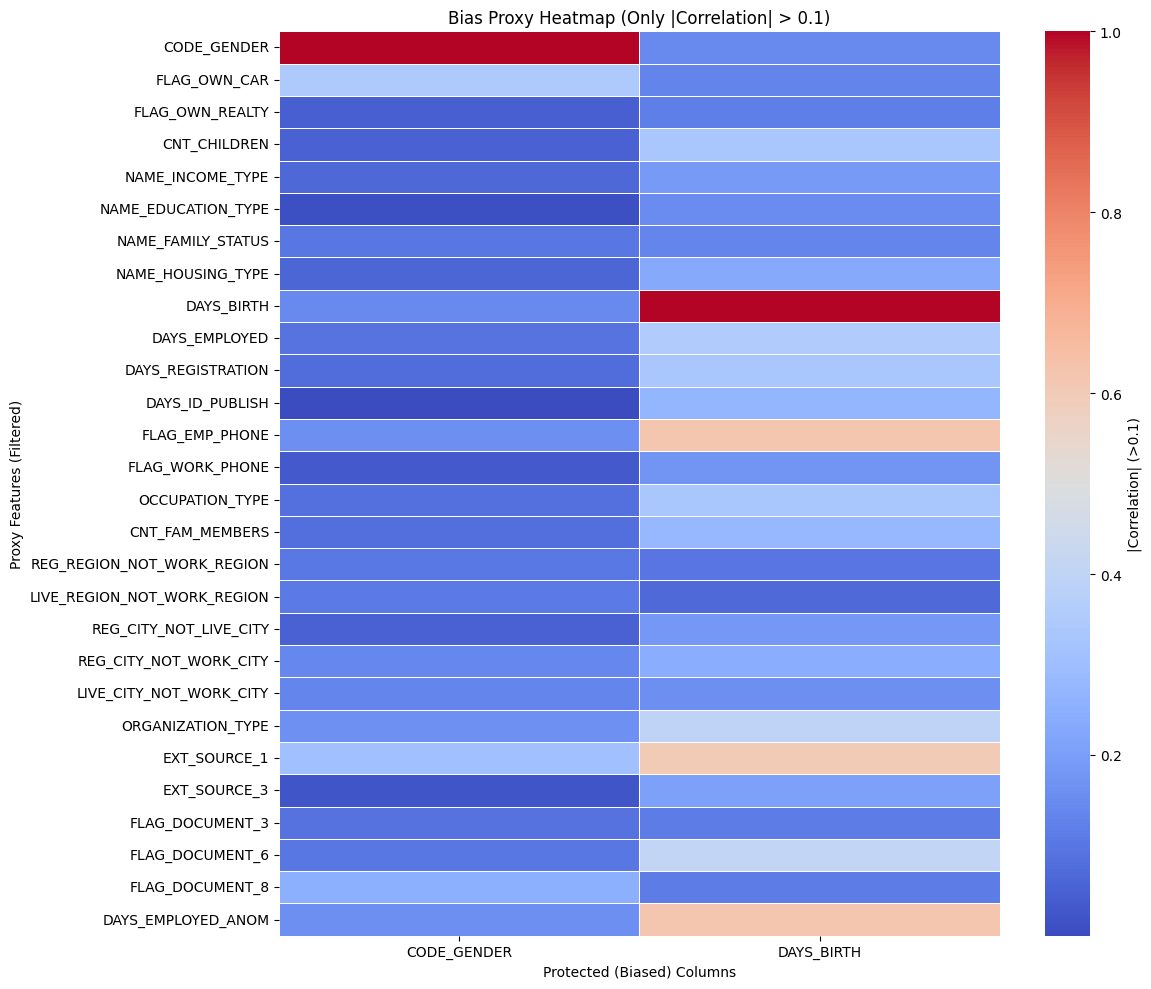

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# corr_sub = corr[valid_bcols]  # Ensure corr_sub already exists

# 1. Identify features with correlation > cutoff with ANY biased column
mask = corr_sub.abs().max(axis=1) > cutoff

# 2. Filter correlation matrix to only proxy features
corr_filtered = corr_sub[mask]

# 3. Plot heatmap of only high-correlation proxy features
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_filtered.abs(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    cbar_kws={'label': f'|Correlation| (>{cutoff})'}
)

plt.title(f"Bias Proxy Heatmap (Only |Correlation| > {cutoff})")
plt.xlabel("Protected (Biased) Columns")
plt.ylabel("Proxy Features (Filtered)")
plt.tight_layout()
plt.show()


So there are a lot of features that are correlated with gender and age. However, if we were to drop all of these features, our model would not be very accurate. To solve this problem, we will run an overlap test to identify features that can cause a positivity violation with our protected classes of gender and age. 

In [46]:
#  0. Convert categorical to numeric for correlation & overlap 
train_corr = make_numeric_for_corr(train)

#  1. Define protected variables 
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']   # core sensitive features

#  2. Create Gender Binary (0 = M, 1 = F) 
train['_GENDER_BIN'] = (train['CODE_GENDER'] == 'F').astype(int)

#  3. Create Age Group Bins for positivity testing 
# DAYS_BIRTH is negative in Home Credit, so invert it:
train['_AGE'] = -train['DAYS_BIRTH']

# Use quartiles for overlap testing
train['_AGE_BIN'] = pd.qcut(train['_AGE'], q=4, labels=False, duplicates='drop')

#  4. Define candidate (non-protected) features 
protected_vars = biased_cols + ['_GENDER_BIN', '_AGE_BIN', '_AGE']

candidate_features = [
    c for c in train.columns 
    if c not in protected_vars and c not in ['TARGET']
]

print("Number of candidate features:", len(candidate_features))


#  5. POSITIVITY TEST FOR GENDER (M vs F) 

female_unique = train.loc[train['_GENDER_BIN'] == 1, candidate_features].nunique()
viol_female = list(female_unique[female_unique < 2].index)

male_unique   = train.loc[train['_GENDER_BIN'] == 0, candidate_features].nunique()
viol_male = list(male_unique[male_unique < 2].index)

print("\n Gender Positivity Violations ")
print("Violates for FEMALES:", viol_female)
print("Violates for MALES:", viol_male)


#  6. POSITIVITY TEST FOR AGE (each age bin) 

viol_age_bins = {}

for age_group in sorted(train['_AGE_BIN'].dropna().unique()):
    gmask = train['_AGE_BIN'] == age_group
    nunique_vals = train.loc[gmask, candidate_features].nunique()
    viol = list(nunique_vals[nunique_vals < 2].index)
    viol_age_bins[int(age_group)] = viol

print("\n Age Positivity Violations ")
for k, v in viol_age_bins.items():
    print(f"Age bin {k}: {v}")


#  7. Combine all violations 

positivity_violations = set(viol_female) | set(viol_male)

for vlist in viol_age_bins.values():
    positivity_violations |= set(vlist)

positivity_violations = sorted(positivity_violations)

print("\n ALL Positivity Violations Across Gender + Age ")
print(positivity_violations)


Number of candidate features: 116

 Gender Positivity Violations 
Violates for FEMALES: ['FLAG_MOBIL']
Violates for MALES: []

 Age Positivity Violations 
Age bin 0: ['FLAG_DOCUMENT_12']
Age bin 1: ['FLAG_MOBIL']
Age bin 2: ['FLAG_MOBIL']
Age bin 3: ['FLAG_MOBIL', 'FLAG_DOCUMENT_12']

 ALL Positivity Violations Across Gender + Age 
['FLAG_DOCUMENT_12', 'FLAG_MOBIL']


This is a very interesting result. The test we just ran studied the dataset for positivity (overlap) violations. In the certain protected groups, these two features showed no variability. For females for example, the FLAG_MOBIL variable always has the same result. This flag also presents itself as an age-related bias. With a lack of variability, these features still reinforce structural bias and undermine the fairness adjusted modeling technique. 

In [47]:
# Last step: Drop all the biased columns from the unbiased set

all_biased_to_drop = set(biased_cols) | set(proxy_features) | set(positivity_violations)

print("Dropping these biased features:", all_biased_to_drop)

train_unbiased = train.drop(columns=all_biased_to_drop)
test_unbiased = test.drop(columns=all_biased_to_drop)

print(f"Dropped {len(all_biased_to_drop)} features. This is {(len(all_biased_to_drop) / len(train_biased.columns)) * 100:.2f}% of the original.")


Dropping these biased features: {'FLAG_OWN_REALTY', 'CODE_GENDER', 'FLAG_DOCUMENT_6', 'FLAG_MOBIL', 'DAYS_BIRTH', 'FLAG_OWN_CAR', 'REG_REGION_NOT_WORK_REGION', 'NAME_HOUSING_TYPE', 'CNT_CHILDREN', 'LIVE_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_12', 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE', 'DAYS_REGISTRATION', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'DAYS_EMPLOYED_ANOM', 'FLAG_DOCUMENT_8', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_3', 'EXT_SOURCE_3', 'LIVE_REGION_NOT_WORK_REGION'}
Dropped 30 features. This is 25.21% of the original.


It is important to note that most columns dropped here explode the dimensionality when the data is one-hot encoded. 

In [48]:
# Run biased pipeline
X_biased_enc, X_test_biased_enc, y_biased, feature_names_biased, ct_biased = \
    preprocess_and_encode(train_biased, test_biased)

print("Biased train shape:", X_biased_enc.shape)
print("Biased test shape:", X_test_biased_enc.shape)

# Run unbiased pipeline
X_unbiased_enc, X_test_unbiased_enc, y_unbiased, feature_names_unbiased, ct_unbiased = \
    preprocess_and_encode(train_unbiased, test_unbiased)

print("Unbiased train shape:", X_unbiased_enc.shape)
print("Unbiased test shape:", X_test_unbiased_enc.shape)

Biased train shape: (307511, 230)
Biased test shape: (48744, 230)
Unbiased train shape: (307511, 102)
Unbiased test shape: (48744, 102)


# Training Biased and Unbiased Models

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
import seaborn as sns
from sklearn.model_selection import cross_val_predict

def scores(y_true, y_pred, y_pred_proba, title="Model Evaluation"):
    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Print metric summary
    print(f"{title}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC-AUC:", auc)
    print("\nConfusion Matrix (Raw Values):\n", cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


What I will eventually do is quantify how much the feature input weights in the model that has more features has on the output by directly comparing the two models. I will then need a vector which quantifies and tells the BIASED model how to adjust the weight of the input features to be unbiased, and the same for the inverse task (make an unbiased model biased). 


LightGBM (UNBIASED)


/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Docum


LightGBM CV Scores
Model Evaluation (unbiased)
Accuracy: 0.6804959822575453
Precision: 0.14554530006951416
Recall: 0.6072507552870091
F1: 0.2348112553640548
ROC-AUC: 0.7007907114658314

Confusion Matrix (Raw Values):
 [[194185  88501]
 [  9750  15075]]


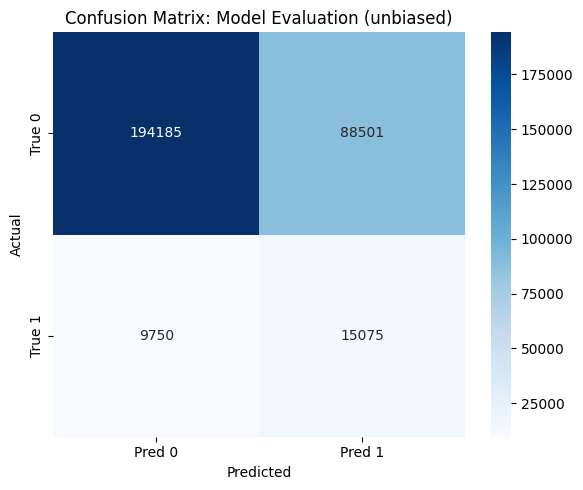

/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Top 20 LightGBM Features:
remainder__AMT_ANNUITY                   2029
remainder__AMT_CREDIT                    1897
remainder__AMT_GOODS_PRICE               1745
remainder__EXT_SOURCE_2                  1595
remainder__DAYS_LAST_PHONE_CHANGE        1318
remainder__AMT_INCOME_TOTAL               900
remainder__OWN_CAR_AGE                    783
remainder__REGION_POPULATION_RELATIVE     743
remainder__AMT_REQ_CREDIT_BUREAU_YEAR     656
remainder__TOTALAREA_MODE                 511
remainder__LANDAREA_AVG                   421
remainder__LANDAREA_MODE                  389
remainder__BASEMENTAREA_AVG               376
remainder__AMT_REQ_CREDIT_BUREAU_QRT      361
remainder__APARTMENTS_AVG                 353
remainder__COMMONAREA_MODE                351
remainder__COMMONAREA_AVG                 350
binary__NAME_CONTRACT_TYPE                349
remainder__APARTMENTS_MODE                345
remainder__NONLIVINGAREA_AVG              341
dtype: int32

LightGBM (BIASED)


/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/qayyuma/Docum


LightGBM CV Scores
Model Evaluation (biased)
Accuracy: 0.7159971513214162
Precision: 0.17207877369873362
Recall: 0.6606646525679758
F1: 0.2730405540387561
ROC-AUC: 0.759243875748423

Confusion Matrix (Raw Values):
 [[203776  78910]
 [  8424  16401]]


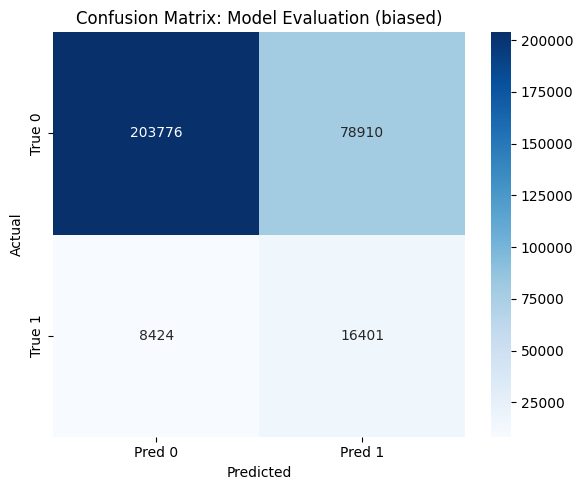

/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Top 20 LightGBM Features:
remainder__EXT_SOURCE_1                  1695
remainder__EXT_SOURCE_3                  1669
remainder__EXT_SOURCE_2                  1254
remainder__AMT_CREDIT                    1191
remainder__DAYS_EMPLOYED                 1142
remainder__DAYS_BIRTH                    1093
remainder__AMT_ANNUITY                   1036
remainder__AMT_GOODS_PRICE                940
remainder__DAYS_ID_PUBLISH                858
remainder__DAYS_LAST_PHONE_CHANGE         709
remainder__DAYS_REGISTRATION              681
remainder__OWN_CAR_AGE                    556
remainder__AMT_INCOME_TOTAL               527
remainder__REGION_POPULATION_RELATIVE     468
remainder__AMT_REQ_CREDIT_BUREAU_YEAR     362
remainder__APARTMENTS_MODE                250
remainder__TOTALAREA_MODE                 250
remainder__AMT_REQ_CREDIT_BUREAU_QRT      207
onehot__CODE_GENDER_F                     201
remainder__LANDAREA_AVG                   194
dtype: int32


In [33]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
import pandas as pd

# Shared LightGBM configuration
lgbm_params = dict(
    objective="binary",
    metric="auc",
    boosting_type="gbdt",
    n_estimators=800,
    learning_rate=0.02,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    verbose=-1,
)

# Dataset registry
datasets = {
    "unbiased": {
        "X_train": X_unbiased_enc,
        "y_train": y_unbiased,
        "X_test": X_test_unbiased_enc,
        "feature_names": feature_names_unbiased,
    },
    "biased": {
        "X_train": X_biased_enc,
        "y_train": y_biased,
        "X_test": X_test_biased_enc,
        "feature_names": feature_names_biased,
    },
}

# Containers for results
cv_results = {}
test_predictions = {}
feature_importance = {}
models = {}

# Train + evaluate both datasets
for name, data in datasets.items():
    print(f"\nLightGBM ({name.upper()})")

    model = LGBMClassifier(**lgbm_params)

    # Cross-validated predictions
    y_pred = cross_val_predict(
        model,
        data["X_train"],
        data["y_train"],
        cv=5,
        method="predict",
    )

    y_pred_proba = cross_val_predict(
        model,
        data["X_train"],
        data["y_train"],
        cv=5,
        method="predict_proba",
    )[:, 1]

    print("\nLightGBM CV Scores")
    scores(data["y_train"], y_pred, y_pred_proba, title=f"Model Evaluation ({name})")

    # Store CV results
    cv_results[name] = {
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
    }

    # Fit final model on full training data
    model.fit(data["X_train"], data["y_train"])
    models[name] = model

    # Test predictions
    test_predictions[name] = model.predict_proba(data["X_test"])[:, 1]

    # Feature importance
    fi = pd.Series(
        model.feature_importances_,
        index=data["feature_names"],
    ).sort_values(ascending=False)

    feature_importance[name] = fi

    print("\nTop 20 LightGBM Features:")
    print(fi.head(20))


https://github.com/lamchr/nsmo_poc/blob/main/nsmo_poc.ipynb

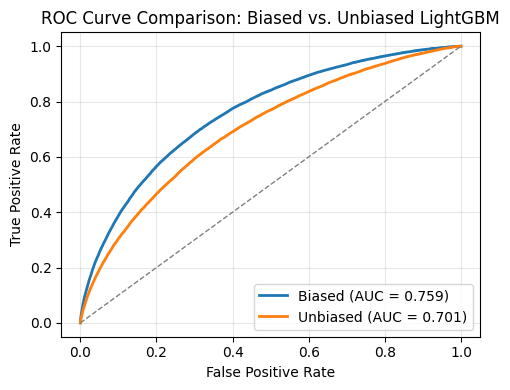

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(5,4))

for name in ["biased", "unbiased"]:
    y_true = datasets[name]["y_train"]
    y_proba = cv_results[name]["y_pred_proba"]

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        linewidth=2,
        label=f"{name.capitalize()} (AUC = {roc_auc:.3f})",
    )

# Random classifier reference line

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Biased vs. Unbiased LightGBM")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("roc_comparison.png", dpi=384, bbox_inches="tight", pad_inches=0)
plt.show()


I want to study how the data has changed without the biased features. I will run PCA on the data and plot the results and display the clusters. 

Scaling Separately
Performing PCA


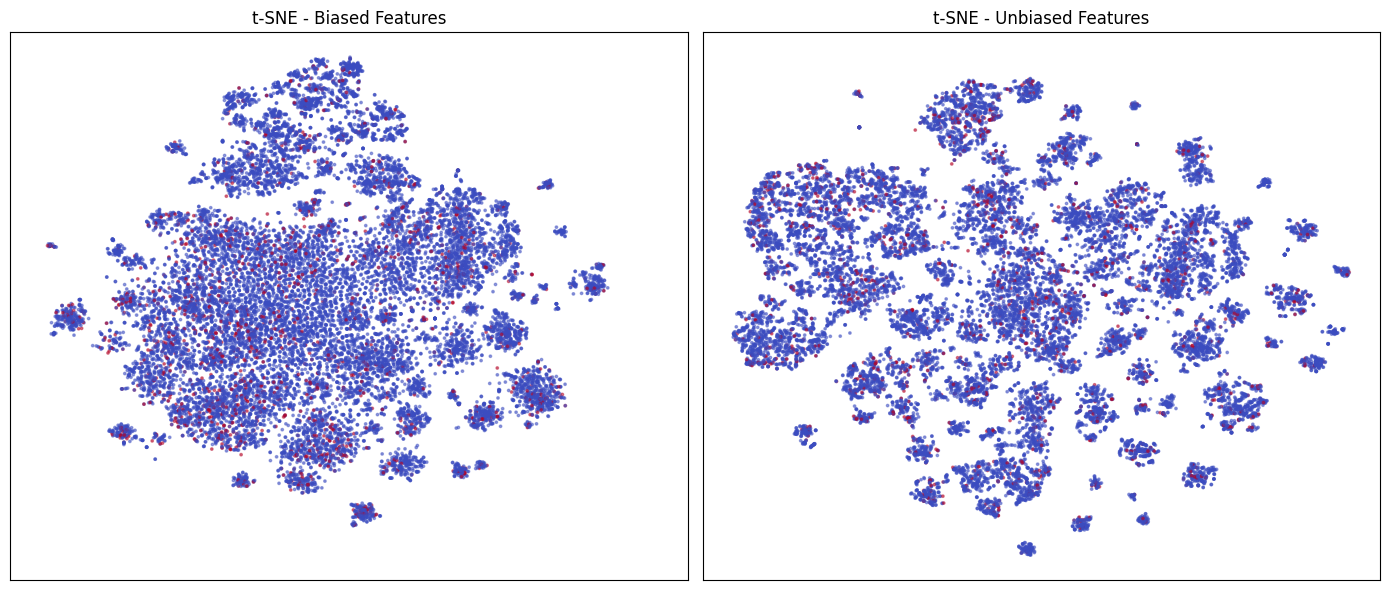

In [57]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Configuration
RANDOM_STATE = 42
N_SAMPLES = 20_000

# Subsample identical rows
rng = np.random.default_rng(RANDOM_STATE)
idx = rng.choice(X_biased_enc.shape[0], size=N_SAMPLES, replace=False)

Xb = X_biased_enc[idx]
Xu = X_unbiased_enc[idx]

y_sub = (
    y_biased.iloc[idx]
    if hasattr(y_biased, "iloc")
    else y_biased[idx]
)

# Impute separately (CRITICAL)
imputer_b = SimpleImputer(strategy="median")
imputer_u = SimpleImputer(strategy="median")

Xb_imp = imputer_b.fit_transform(Xb)
Xu_imp = imputer_u.fit_transform(Xu)

# Scale separately
print("Scaling Separately")
scaler_b = StandardScaler()
scaler_u = StandardScaler()

Xb_scaled = scaler_b.fit_transform(Xb_imp)
Xu_scaled = scaler_u.fit_transform(Xu_imp)

# PCA separately
print("Performing PCA")
pca_b = PCA(n_components=50, random_state=RANDOM_STATE)
pca_u = PCA(n_components=50, random_state=RANDOM_STATE)

Xb_pca = pca_b.fit_transform(Xb_scaled)
Xu_pca = pca_u.fit_transform(Xu_scaled)

# t-SNE (separate instances)
tsne_params = dict(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=RANDOM_STATE,
)

tsne_b = TSNE(**tsne_params)
tsne_u = TSNE(**tsne_params)

Xb_tsne = tsne_b.fit_transform(Xb_pca)
Xu_tsne = tsne_u.fit_transform(Xu_pca)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(
    Xb_tsne[:, 0],
    Xb_tsne[:, 1],
    c=y_sub,
    cmap="coolwarm",
    s=3,
    alpha=0.5,
)
axes[0].set_title("t-SNE - Biased Features")

axes[1].scatter(
    Xu_tsne[:, 0],
    Xu_tsne[:, 1],
    c=y_sub,
    cmap="coolwarm",
    s=3,
    alpha=0.5,
)
axes[1].set_title("t-SNE - Unbiased Features")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


Running UMAP


/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


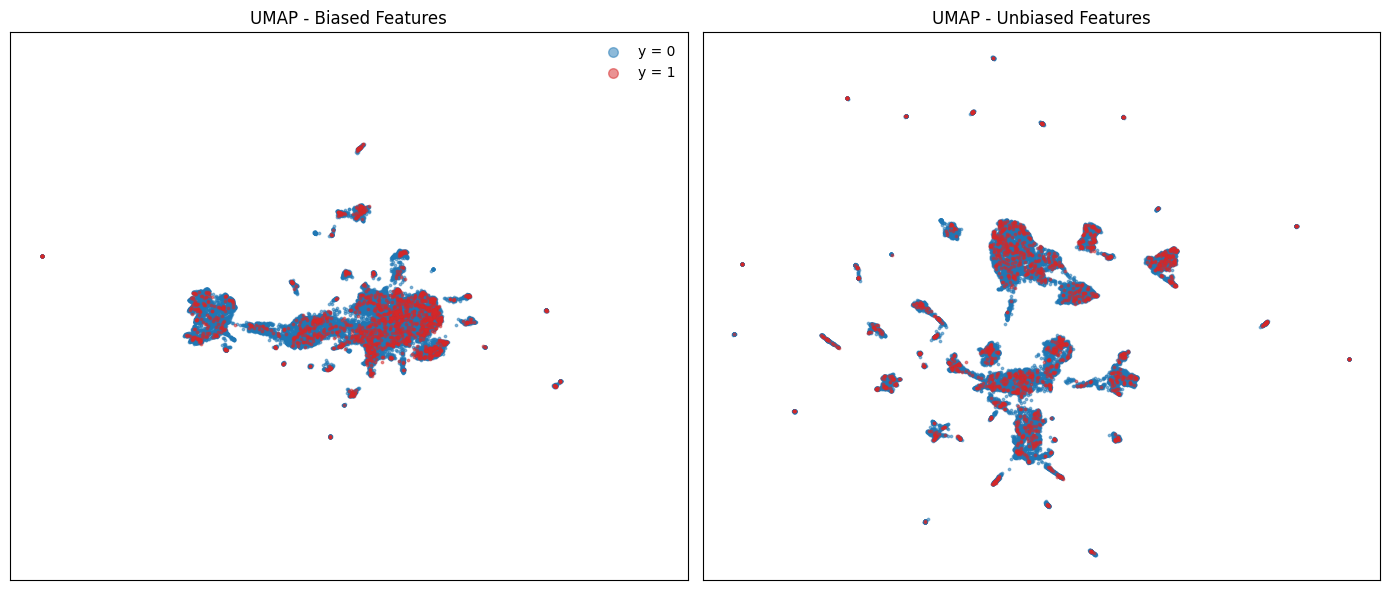

In [58]:
# UMAP (separate instances)
import umap

print("Running UMAP")

umap_params = dict(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=RANDOM_STATE,
)

umap_b = umap.UMAP(**umap_params)
umap_u = umap.UMAP(**umap_params)

Xb_umap = umap_b.fit_transform(Xb_pca)
Xu_umap = umap_u.fit_transform(Xu_pca)

# Plot (binary coloring)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Masks for classes
mask_0 = y_sub == 0
mask_1 = y_sub == 1

# Biased
axes[0].scatter(
    Xb_umap[mask_0, 0],
    Xb_umap[mask_0, 1],
    c="tab:blue",
    s=3,
    alpha=0.5,
    label="y = 0",
)
axes[0].scatter(
    Xb_umap[mask_1, 0],
    Xb_umap[mask_1, 1],
    c="tab:red",
    s=3,
    alpha=0.5,
    label="y = 1",
)
axes[0].set_title("UMAP - Biased Features")
axes[0].legend(markerscale=4, frameon=False)

# Unbiased
axes[1].scatter(
    Xu_umap[mask_0, 0],
    Xu_umap[mask_0, 1],
    c="tab:blue",
    s=3,
    alpha=0.5,
)
axes[1].scatter(
    Xu_umap[mask_1, 0],
    Xu_umap[mask_1, 1],
    c="tab:red",
    s=3,
    alpha=0.5,
)
axes[1].set_title("UMAP - Unbiased Features")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


I want to answer this question: How would the biased model behave if it were forced to act like the unbiased model, and which biased features prevent that?

In [ ]:
p_u = cv_results["unbiased"]["y_pred_proba"]
p_b = cv_results["biased"]["y_pred_proba"]

delta = p_b - p_u

biased_only_features = list(
    set(feature_names_biased) - set(feature_names_unbiased)
)

X_bias_only = X_biased_enc[:, 
    [feature_names_biased.index(f) for f in biased_only_features]
]

from sklearn.linear_model import ElasticNet

explainer = ElasticNet(
    alpha=0.01,
    l1_ratio=0.5,
    random_state=42
)

explainer.fit(X_bias_only, delta)


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [60]:
import shap

explainer_b = shap.TreeExplainer(models["biased"])
explainer_u = shap.TreeExplainer(models["unbiased"])

shap_b = explainer_b.shap_values(X_biased_enc)
shap_u = explainer_u.shap_values(X_unbiased_enc)

delta_shap = shap_b - shap_u_aligned


/Users/qayyuma/Documents/GitHub/credit-risk-prediction-bias/.venv/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


NameError: name 'shap_u_aligned' is not defined